In [1]:
pip install pandas pymysql

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pymysql

In [3]:
import pandas as pd

patients = pd.read_csv("../data/patients_1000.csv")
doctors = pd.read_csv("../data/doctors_1000.csv")
medicines = pd.read_csv("../data/medicines_1000.csv")
prescriptions = pd.read_csv("../data/prescriptions_1000.csv")

print("Files loaded successfully ✅")


Files loaded successfully ✅


In [4]:

import numpy as np

patients = patients.replace({np.nan: None})
doctors = doctors.replace({np.nan: None})
medicines = medicines.replace({np.nan: None})
prescriptions = prescriptions.replace({np.nan: None})



In [5]:
# Handle missing gender
patients['gender'] = patients['gender'].fillna('U')

# Age validation (0–100)
patients = patients[(patients['age'] >= 0) & (patients['age'] <= 100)]

# Remove duplicate patients
patients.drop_duplicates(subset='patient_id', inplace=True)

print("Patients cleaned ✅")


Patients cleaned ✅


In [6]:
# Default values
prescriptions['dosage'] = prescriptions['dosage'].fillna("Not Provided")
prescriptions['frequency'] = prescriptions['frequency'].fillna("Not Provided")

# Remove duplicate prescriptions
prescriptions.drop_duplicates(
    subset=['patient_id','doctor_id','medicine_id','prescribed_date'],
    inplace=True
)

print("Prescriptions cleaned ✅")


Prescriptions cleaned ✅


In [7]:
prescriptions = prescriptions[
    prescriptions['patient_id'].isin(patients['patient_id']) &
    prescriptions['doctor_id'].isin(doctors['doctor_id']) &
    prescriptions['medicine_id'].isin(medicines['medicine_id'])
]

print("Foreign key validation complete ✅")


Foreign key validation complete ✅


In [8]:
connection = pymysql.connect(
    host="localhost",
    user="root",
    password="password",
    database="digital_prescription_db"
)

cursor = connection.cursor()

print("Connected to MySQL ✅")


Connected to MySQL ✅


In [9]:
cursor.execute("SET FOREIGN_KEY_CHECKS = 0")
cursor.execute("TRUNCATE TABLE prescriptions")
cursor.execute("TRUNCATE TABLE patients")
cursor.execute("TRUNCATE TABLE doctors")
cursor.execute("TRUNCATE TABLE medicines")
cursor.execute("SET FOREIGN_KEY_CHECKS = 1")

connection.commit()


In [10]:
patient_query = """
INSERT INTO patients 
(patient_id, patient_name, gender, age, contact_no)
VALUES (%s, %s, %s, %s, %s)
"""

patient_data = patients[['patient_id','patient_name','gender','age','contact_no']].values.tolist()

cursor.executemany(patient_query, patient_data)
connection.commit()

print("Patients inserted ✅")

Patients inserted ✅


In [11]:
doctor_query = """
INSERT INTO doctors
(doctor_id, doctor_name, specialization, hospital_name)
VALUES (%s, %s, %s, %s)
"""

doctor_data = doctors[['doctor_id','doctor_name','specialization','hospital_name']].values.tolist()

cursor.executemany(doctor_query, doctor_data)
connection.commit()

print("Doctors inserted ✅")

Doctors inserted ✅


In [12]:
medicine_query = """
INSERT INTO medicines
(medicine_id, medicine_name, category)
VALUES (%s, %s, %s)
"""

medicine_data = medicines[['medicine_id','medicine_name','category']].values.tolist()

cursor.executemany(medicine_query, medicine_data)
connection.commit()

print("Medicines inserted ✅")


Medicines inserted ✅


In [13]:
prescription_query = """
INSERT INTO prescriptions
(prescription_id, patient_id, doctor_id, medicine_id,
 dosage, frequency, prescribed_date)
VALUES (%s, %s, %s, %s, %s, %s, %s)
"""

prescription_data = prescriptions[
    ['prescription_id','patient_id','doctor_id','medicine_id',
     'dosage','frequency','prescribed_date']
].values.tolist()

cursor.executemany(prescription_query, prescription_data)
connection.commit()

print("Prescriptions inserted ✅")


Prescriptions inserted ✅


In [14]:
cursor.close()
connection.close()

print("ETL Process Completed Successfully 🎉")


ETL Process Completed Successfully 🎉


In [15]:
print(len(patients))
print(len(doctors))
print(len(medicines))
print(len(prescriptions))


488
1000
1000
463


In [16]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt


In [17]:
def get_connection():
    return pymysql.connect(
        host="localhost",
        user="root",
        password="password",
        database="digital_prescription_db"
    )


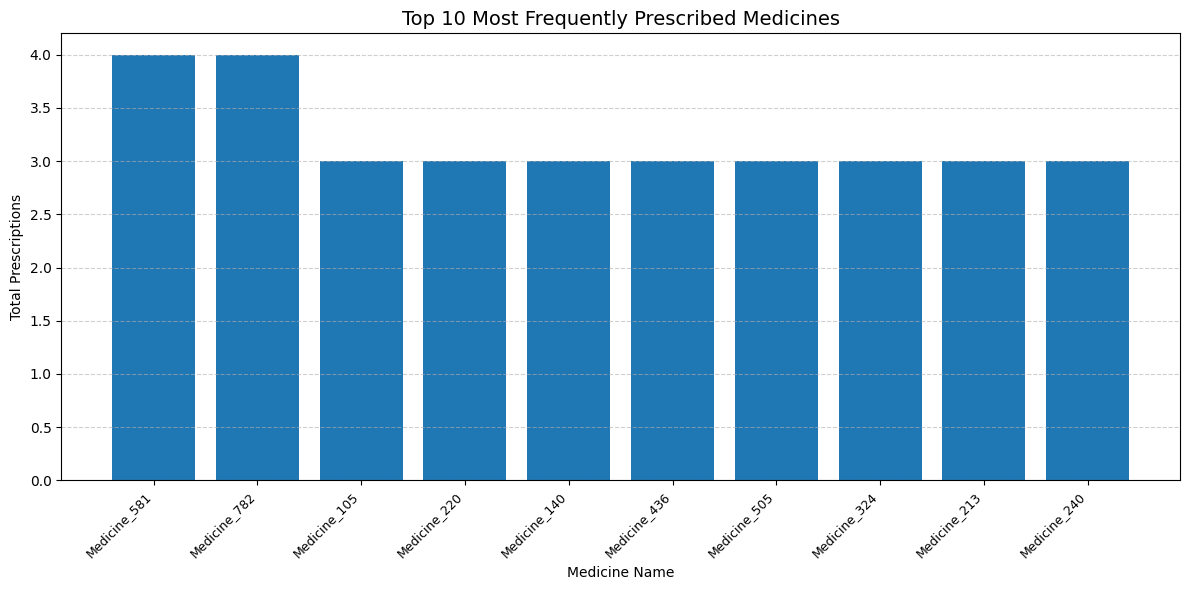

In [30]:
# Most Frequently Prescribed Medicines (Improved Visualization)

connection = get_connection()
cursor = connection.cursor()

query = """
SELECT m.medicine_name, COUNT(*) AS total
FROM prescriptions p
JOIN medicines m ON p.medicine_id = m.medicine_id
GROUP BY m.medicine_name
ORDER BY total DESC
LIMIT 10
"""

cursor.execute(query)
rows = cursor.fetchall()
df = pd.DataFrame(rows, columns=[col[0] for col in cursor.description])

plt.figure(figsize=(12,6))

plt.bar(df['medicine_name'], df['total'])

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title("Top 10 Most Frequently Prescribed Medicines", fontsize=14)
plt.xlabel("Medicine Name")
plt.ylabel("Total Prescriptions")

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

cursor.close()
connection.close()

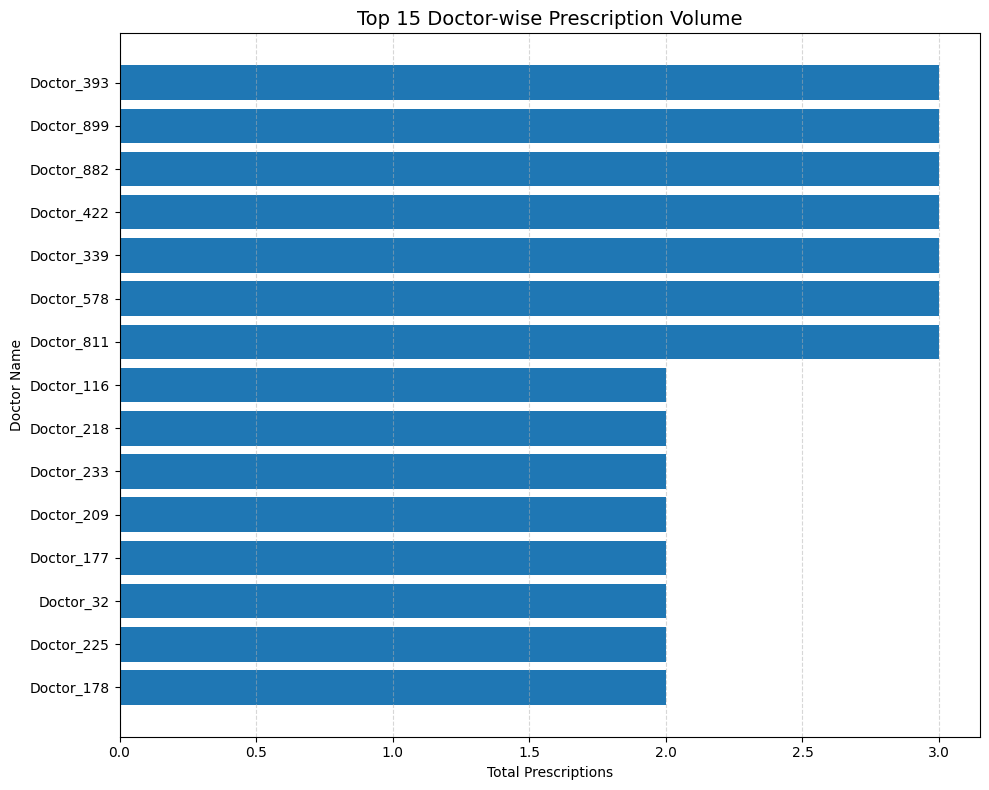

In [31]:
# Doctor-wise Prescription Volume (Improved Version)

connection = get_connection()
cursor = connection.cursor()

query = """
SELECT d.doctor_name, COUNT(*) AS total
FROM prescriptions p
JOIN doctors d ON p.doctor_id = d.doctor_id
GROUP BY d.doctor_name
ORDER BY total DESC
LIMIT 15
"""

cursor.execute(query)
rows = cursor.fetchall()
df = pd.DataFrame(rows, columns=[col[0] for col in cursor.description])

plt.figure(figsize=(10,8))

plt.barh(df['doctor_name'], df['total'])
plt.gca().invert_yaxis()

plt.title("Top 15 Doctor-wise Prescription Volume", fontsize=14)
plt.xlabel("Total Prescriptions")
plt.ylabel("Doctor Name")

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

cursor.close()
connection.close()

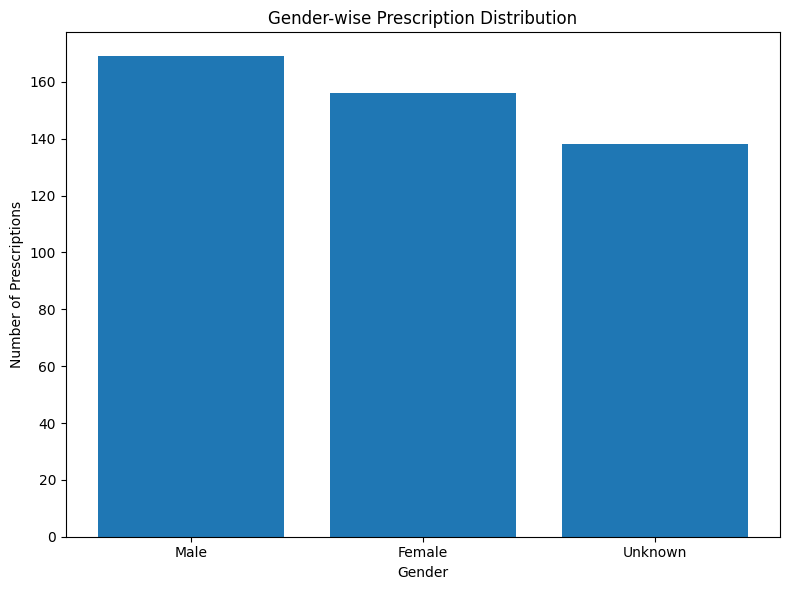

In [22]:
# Gender-wise Prescription Distribution

connection = get_connection()
cursor = connection.cursor()

query = """
SELECT 
    COALESCE(p.gender, 'U') AS gender,
    COUNT(pr.prescription_id) AS total
FROM prescriptions pr
JOIN patients p 
    ON pr.patient_id = p.patient_id
GROUP BY gender
ORDER BY total DESC;
"""

cursor.execute(query)
rows = cursor.fetchall()

# Convert to DataFrame
df = pd.DataFrame(rows, columns=[col[0] for col in cursor.description])

# Optional: Make labels more readable
df['gender'] = df['gender'].replace({
    'M': 'Male',
    'F': 'Female',
    'U': 'Unknown'
})

# Plot
plt.figure(figsize=(8,6))
plt.bar(df['gender'], df['total'])
plt.title("Gender-wise Prescription Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Prescriptions")
plt.tight_layout()
plt.show()

cursor.close()
connection.close()


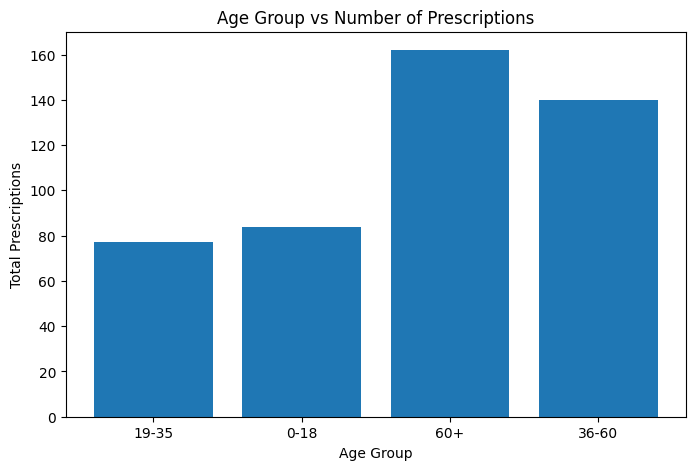

In [23]:
# Age Group vs Number of Prescriptions

connection = get_connection()
cursor = connection.cursor()

query = """
SELECT 
CASE
    WHEN pt.age BETWEEN 0 AND 18 THEN '0-18'
    WHEN pt.age BETWEEN 19 AND 35 THEN '19-35'
    WHEN pt.age BETWEEN 36 AND 60 THEN '36-60'
    ELSE '60+'
END AS age_group,
COUNT(*) AS total
FROM prescriptions p
JOIN patients pt ON p.patient_id = pt.patient_id
GROUP BY age_group
"""

cursor.execute(query)
rows = cursor.fetchall()
df = pd.DataFrame(rows, columns=[col[0] for col in cursor.description])

plt.figure(figsize=(8,5))
plt.bar(df['age_group'], df['total'])
plt.title("Age Group vs Number of Prescriptions")
plt.xlabel("Age Group")
plt.ylabel("Total Prescriptions")
plt.show()

cursor.close()
connection.close()


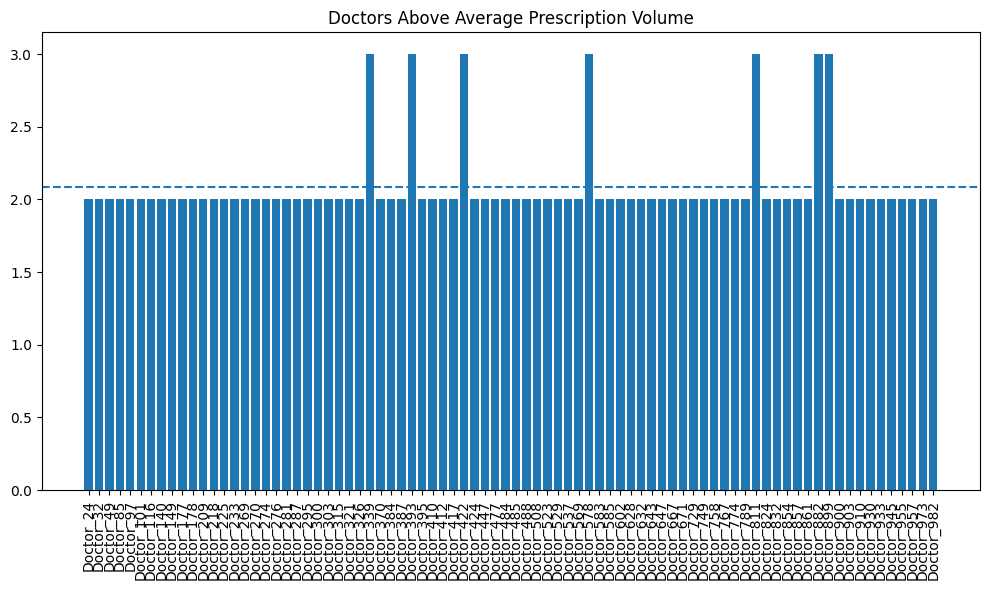

In [24]:
# Detect Doctors Issuing Unusually High Prescriptions

connection = get_connection()
cursor = connection.cursor()

query = """
SELECT d.doctor_name, COUNT(*) AS total
FROM prescriptions p
JOIN doctors d ON p.doctor_id = d.doctor_id
GROUP BY d.doctor_name
HAVING total > (
    SELECT AVG(cnt)
    FROM (
        SELECT COUNT(*) AS cnt
        FROM prescriptions
        GROUP BY doctor_id
    ) AS sub
)
"""

cursor.execute(query)
rows = cursor.fetchall()
df = pd.DataFrame(rows, columns=[col[0] for col in cursor.description])

avg = df['total'].mean()

plt.figure(figsize=(10,6))
plt.bar(df['doctor_name'], df['total'])
plt.axhline(avg, linestyle='--')
plt.xticks(rotation=90)
plt.title("Doctors Above Average Prescription Volume")
plt.tight_layout()
plt.show()

cursor.close()
connection.close()



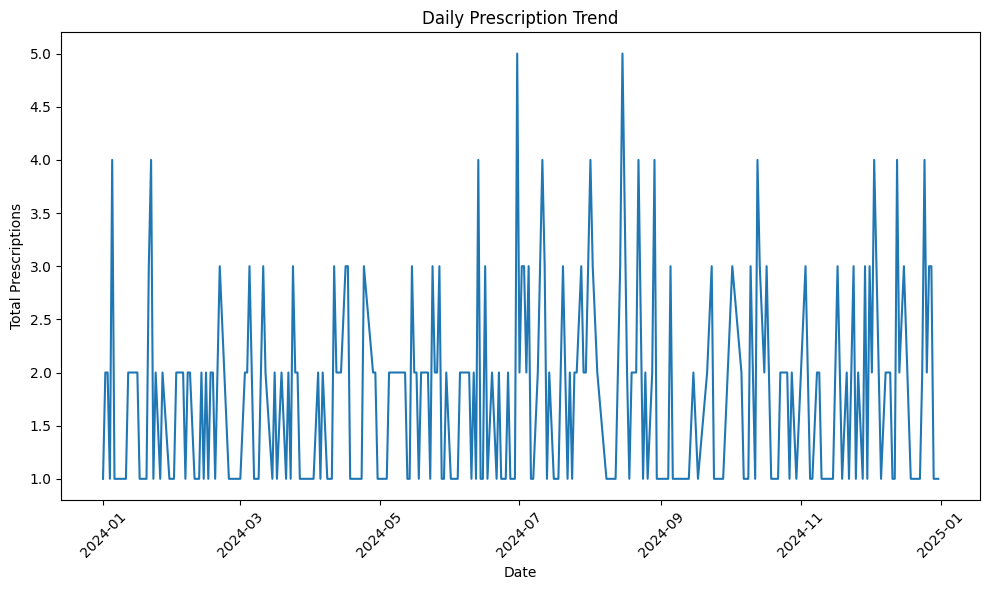

In [25]:
# Daily Prescription Trend

connection = get_connection()
cursor = connection.cursor()

query = """
SELECT prescribed_date, COUNT(*) AS total
FROM prescriptions
GROUP BY prescribed_date
ORDER BY prescribed_date
"""

cursor.execute(query)
rows = cursor.fetchall()

df = pd.DataFrame(rows, columns=[col[0] for col in cursor.description])

plt.figure(figsize=(10,6))
plt.plot(df['prescribed_date'], df['total'])
plt.xticks(rotation=45)
plt.title("Daily Prescription Trend")
plt.xlabel("Date")
plt.ylabel("Total Prescriptions")
plt.tight_layout()
plt.show()

cursor.close()
connection.close()



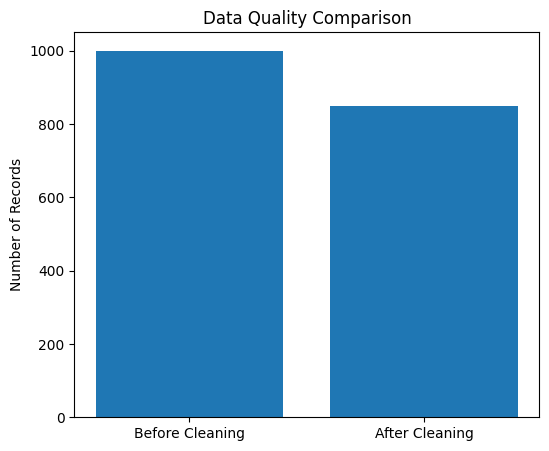

In [26]:
# Data Quality Comparison (Before vs After Cleaning)

before_count = 1000
after_count = 850

plt.figure(figsize=(6,5))
plt.bar(['Before Cleaning', 'After Cleaning'], [before_count, after_count])
plt.title("Data Quality Comparison")
plt.ylabel("Number of Records")
plt.show()

